In [1]:
import os
import pandas as pd
import numpy as np 
import pingouin as pg 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def Get_participants(folder_dir) : 
    participants = os.listdir(folder_dir)
    participants = sorted([ x.split(sep=".")[0] for x in participants if x.endswith(".csv") and not x.startswith(".")])
    

    return participants

def Partis_Dict(folder_dir) : 

    participants = Get_participants( folder_dir )

    participants_dict = { x : None for x  in participants} 
    
    for parti in participants_dict:
        
        arr = pd.read_csv( folder_dir + "/" + parti + ".csv", index_col=0) # , delimiter="," ) #, dtype=float)
        
        participants_dict[parti] = arr.values
    
    return participants_dict


In [3]:
curr_dir = os.getcwd()
rating_dir = curr_dir + "/DynamicRating"

rating = Partis_Dict(rating_dir)

print(len(rating))
print(rating[next(iter(rating))].shape)

52
(12000, 16)


In [4]:
avg_rating_arr = []

for participant in rating : 
    avg_rating_arr.append(rating[participant].mean(axis=0))

avg_rating_arr = np.array(avg_rating_arr)
se_rating = [ np.std(avg_rating_arr.mean(axis=0)[x:x+4]) / np.sqrt(5) for x in range(0,16,4)]


avg_rating_arr.shape

(52, 16)

findfont: Font family ['Helvitica'] not found. Falling back to DejaVu Sans.


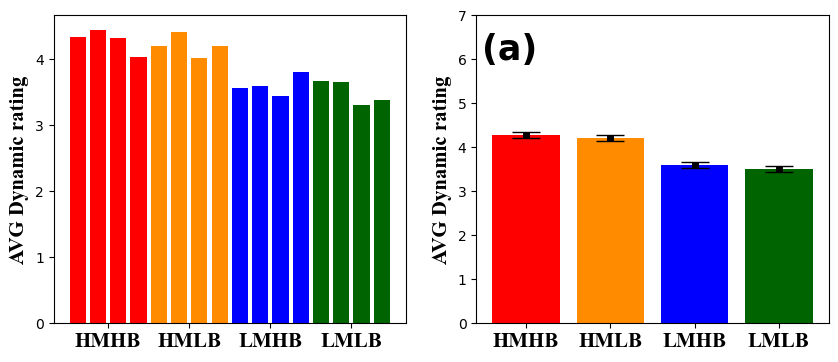

In [5]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,4)

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }


axs[0].bar(range(16), avg_rating_arr.mean(axis=0), color = np.repeat(colors, 4) )
axs[0].set_ylabel("AVG Dynamic rating", fontsize = 15,family = "Times New Roman", weight='bold' );
axs[0].set_xticks( [ 1.5, 5.5, 9.5, 13.5], block_names, fontsize = 15, family = "Times New Roman", weight='bold' );

axs[1].bar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1), color = colors )
axs[1].set_xticks(range(4), block_names , fontsize = 15, family = "Times New Roman", weight='bold' );
axs[1].set_ylabel("AVG Dynamic rating", fontsize = 15,family = "Times New Roman", weight='bold' );
axs[1].set_ylim(0,7)
axs[1].errorbar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1),yerr = se_rating, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
axs[1].text(-0.2,6.,'(a)', ha ='center', fontsize = 25, family = 'Helvitica', weight='bold' )

y = avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1) + 0.3
# for i, blc in enumerate( y ): 
#     plt.text(x = i, y= y[i], s= round(blc, 2), fontdict=font_dict, color='black')

In [6]:
data = avg_rating_arr.reshape(-1,4).mean(axis=1).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_rating_arr)
names = np.repeat(np.arange(len(avg_rating_arr)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
print(results)


post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
print("-"*100,'\n')
print(post_hoc[['A','B','T','p-unc']].round(4))
print("="*100,'\n') 

   Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  blocks      3    153  21.941793  7.134237e-12  1.759512e-10  0.117513   

        eps  sphericity   W-spher   p-spher  
0  0.855662       False  0.755937  0.016198  
---------------------------------------------------------------------------------------------------- 

      A     B       T   p-unc
0  HMHB  HMLB  0.6511  0.5179
1  HMHB  LMHB  5.6608  0.0000
2  HMHB  LMLB  5.4041  0.0000
3  HMLB  LMHB  4.8005  0.0000
4  HMLB  LMLB  5.7528  0.0000
5  LMHB  LMLB  0.9003  0.3722



In [7]:
sampling_rate = 100
video_len = 120 
window_size = 1

window_rating_arr = []

for participant in rating :
    
    data = rating[participant]

    participant_arr = []

    for index in range(video_len - window_size +1) :

        if index*sampling_rate + window_size*sampling_rate <= len(data) : 
            arr = data[index*sampling_rate : index*sampling_rate + window_size*sampling_rate]
        
        else :
            arr = data[index*sampling_rate : len(data)]

        participant_arr.append(arr.mean(axis=0))

    window_rating_arr.append(participant_arr)

window_rating_arr = np.array(window_rating_arr)

window_rating_arr.shape


(52, 120, 16)

In [14]:
save_dir = os.getcwd() + "/Window_data/Dynamic_rating"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for ind, participant in enumerate(window_rating_arr) :
    np.savetxt(save_dir + f"/{ind}.csv", participant, delimiter = ",")

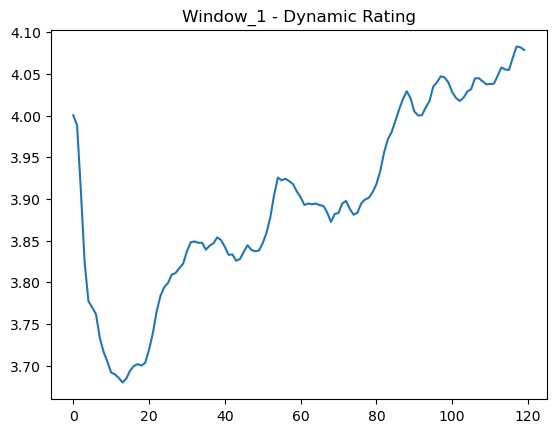

In [8]:
fig = plt.figure()

plt.plot(range(window_rating_arr.shape[1]), window_rating_arr.mean((0,2)))
#plt.xlim(0,)
plt.title("Window_{0} - Dynamic Rating".format(window_size));

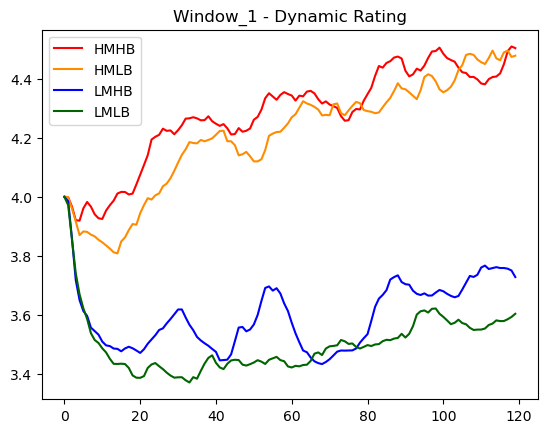

In [9]:
block_data = np.array( [window_rating_arr.mean(axis=0)[:, x:x+4].mean(axis=1) for x in range(0,16,4) ]  )

fig = plt.figure()

for block in range(len(block_data)) :
    plt.plot(range(window_rating_arr.shape[1]), block_data[block], color = colors[block])
plt.legend(block_names)
plt.title("Window_{0} - Dynamic Rating".format(window_size));

In [10]:
# block_data = np.array( [window_rating_arr.mean(axis=0)[:, x:x+8].mean(axis=1) for x in range(0,16,8) ]  )

# fig = plt.figure()

# colors = ['r','b']
# block_names = ["HM", 'LM']

# for block in range(len(block_data)) :
#     plt.plot(range(window_rating_arr.shape[1]), block_data[block], color = colors[block])
# plt.legend(block_names)
# plt.title("Window_{0} - Dynamic Rating".format(window_size));

In [11]:
AVG_dir = curr_dir + "/AVG"

if not os.path.isdir(AVG_dir):
    os.mkdir(AVG_dir)

df = pd.DataFrame(avg_rating_arr)
df.to_csv(AVG_dir + "/Dynamic_Rating.csv")

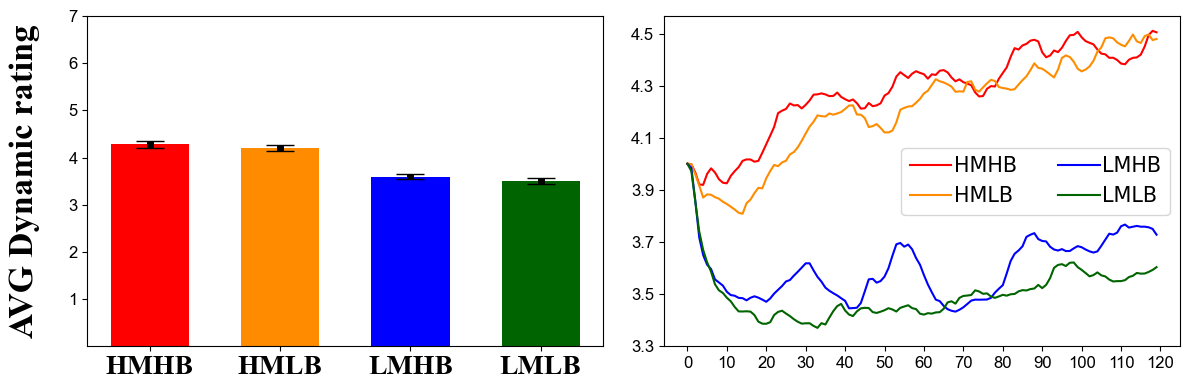

In [12]:
def singnificantLine(ax, x1, x2, y, text, font_size = 15, ha_ = 'center',family_ = 'Times New Roman', weight_ ='bold' ):
    ax.hlines(y, x1, x2, colors='gray', linestyles='solid')
    ax.vlines(x1, y, y-(x2-x1)/ 10, colors='gray', linestyles='solid')
    ax.vlines(x2, y, y-(x2-x1)/ 10, colors='gray', linestyles='solid')
    ax.text( (x1+x2)/2, y, text, fontsize = font_size, ha = ha_,family = family_, weight=weight_)

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }

fig, axs = plt.subplots(1,2)
fig.set_size_inches((12,4))

axs[0].bar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1), color = colors,width = 0.6 )
axs[0].set_xticks(range(4), block_names , fontsize = 20, family = "Times New Roman", weight='bold' );
axs[0].set_yticks(range(1,8), range(1,8),fontsize=13)
axs[0].set_ylabel("AVG Dynamic rating", fontsize = 25 ,family = "Times New Roman", weight='bold', labelpad = 20 );
axs[0].set_ylim(0,7)
axs[0].set_yticklabels(axs[0].get_yticks(), family = 'Arial', fontsize=12)
axs[0].errorbar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1),yerr = se_rating, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
#axs[0].text(-0.225,6.1,'(a)', ha ='center', fontsize = 25, family = 'Arial', weight='bold' )
# singnificantLine(axs[0], 0, 2, 5.7, '**')
# singnificantLine(axs[0], 0, 3, 6.2, '**')
# singnificantLine(axs[0], 1, 2, 4.6, '**')
# singnificantLine(axs[0], 1, 3, 5.1, '**')

for block in range(len(block_data)) :
    axs[1].plot(range(window_rating_arr.shape[1]), block_data[block], color = colors[block])

axs[1].set_yticks(np.arange(3.3,4.65, 0.2).round(2), np.arange(3.3,4.6,0.2).round(2),fontsize=12, family= 'Arial')
#axs[1].text(3,4.4 ,'(b)', ha ='center', fontsize = 25, family = 'Arial', weight='bold' )
#axs[1].set_ylabel("AVG Dynamic rating", fontsize = 20,family = "Times New Roman", weight='bold' );

axs[1].set_xticks(range(0,121, 10), range(0,121, 10), fontsize=12, family='Arial')
axs[1].legend(block_names, ncol=2,loc = 5,fontsize= 15,handletextpad = 0.1)

plt.tight_layout(w_pad=2)


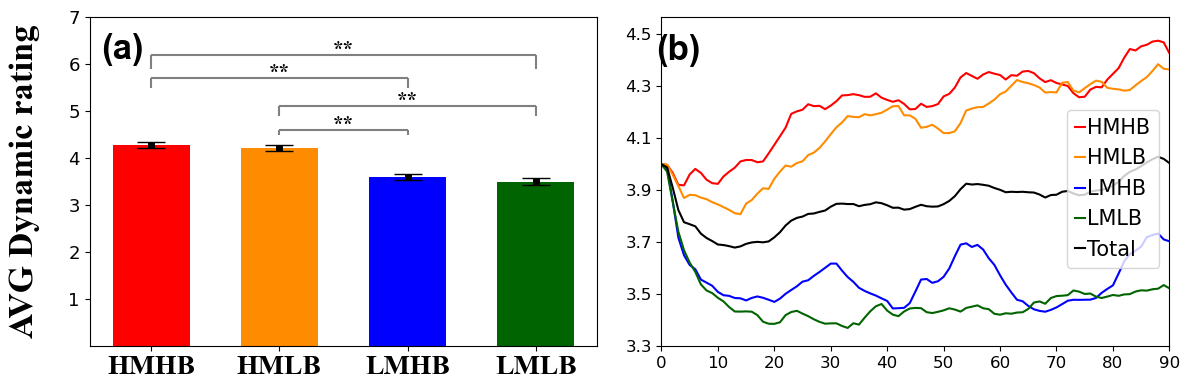

In [13]:
colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }

fig, axs = plt.subplots(1,2)
fig.set_size_inches((12,4))

axs[0].bar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1), color = colors,width = 0.6 )
axs[0].set_xticks(range(4), block_names , fontsize = 20, family = "Times New Roman", weight='bold' );
axs[0].set_yticks(range(1,8), range(1,8),fontsize=13)
axs[0].set_ylabel("AVG Dynamic rating", fontsize = 25 ,family = "Times New Roman", weight='bold', labelpad = 20 );
axs[0].set_ylim(0,7)
axs[0].errorbar(range(4), avg_rating_arr.mean(axis=0).reshape(-1,4).mean(axis=1),yerr = se_rating, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
axs[0].text(-0.225,6.1,'(a)', ha ='center', fontsize = 25, family = 'Arial', weight='bold' )
singnificantLine(axs[0], 0, 2, 5.7, '**')
singnificantLine(axs[0], 0, 3, 6.2, '**')
singnificantLine(axs[0], 1, 2, 4.6, '**')
singnificantLine(axs[0], 1, 3, 5.1, '**')

for block in range(len(block_data)) :
    axs[1].plot(range(window_rating_arr.shape[1]), block_data[block], color = colors[block])
axs[1].plot(range(window_rating_arr.shape[1]), block_data.mean(axis=0), color = 'black')

axs[1].set_yticks(np.arange(3.3,4.6, 0.2).round(2), np.arange(3.3,4.6,0.2).round(2),fontsize=12)
axs[1].text(3,4.4 ,'(b)', ha ='center', fontsize = 25, family = 'Arial', weight='bold' )
#axs[1].set_ylabel("AVG Dynamic rating", fontsize = 20,family = "Times New Roman", weight='bold' );

axs[1].set_xticks(range(0,91, 10), range(0,91, 10), fontsize=12)
axs[1].set_xlim(0,90)
axs[1].legend( np.append(np.array(block_names),'Total'),loc = 0,fontsize= 15,handlelength = 0.5,handletextpad = 0.1, bbox_to_anchor = (1,0.75))

plt.tight_layout(w_pad=2)